In [4]:
from pyspark.sql import Window, SparkSession
import pyspark.sql.functions as F

import os
import json
import random
import sklearn
import numpy as np
import pandas as pd

from os import listdir
import statsmodels.api as sm
import matplotlib.pyplot as plt
from os.path import isfile, join

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

def read_json(path):
    with open(path) as f:
        d = json.load(f)
        return d

def read_txt(path):
    with open(path) as f:
        return f.read()


def get_files(path):
    return [f for f in listdir(path) if isfile(join(path, f))]


def get_directories(path):
    return [name for name in os.listdir(path) if name != ".DS_Store" and name != "README.txt"]

# Part 1: get the data

### Request data

In [14]:
data_route_day = []
requests_folders = "./data/requests/"
directories = get_directories(requests_folders)

# Iterate over all directories
for directory in directories:
    route_day_directory = requests_folders+directory
    files_route_day = get_files(route_day_directory)
    # Iterate over each request file in the directory
    for request_json in files_route_day:
        
        request_path = route_day_directory + "/" + request_json
        request_dict = read_json(request_path)
        for indx, route_point in enumerate(request_dict['tasks']):
            
            timeWindow = route_point['timeWindow']
            address = route_point['address']
            
            # Create row for each location 
            data_point = {
                          **timeWindow, 
                          **address, 
                          'id': route_point['id'], 
                          'request_id': request_dict['id'],
                          'configurationName': request_dict['configurationName'],
                          'request_file_name': request_json.split(".")[0]
                         }
            
            data_route_day.append(data_point)
            
request_full_df = pd.DataFrame(data_route_day)

### Response data

In [ ]:
data_route_day = []
responses_folders = "./data/responses/"
directories = get_directories(responses_folders)

response_dfs = []
# Iterate over all directories
for directory in directories:
    route_day_directory = responses_folders+directory
    files_route_day = get_files(route_day_directory)
    # Iterate over each response file in the directory
    for response in files_route_day:
        response_path = route_day_directory + "/" + response
        response_txt = read_txt(response_path)
        
        order_ids = response_txt.split("\n")
        length = len(order_ids)
        response_file_name = [response.split(".")[0]]*length
        
        response_df = pd.DataFrame({"id":order_ids, 
                                    "request_file_name":response_file_name
                                   })
        response_dfs.append(response_df)
        
response_full_df = pd.concat(response_dfs)

---

### Join responses with requests
to order the points in accord with responses

In [ ]:
merged = pd.merge(response_full_df, 
                  request_full_df, 
                  on = ["request_file_name", "id"])

### Add next latitude  & longitude

In [ ]:
merged['latitude_next'] = (merged.groupby(['request_file_name'])['latitude'].shift(-1))
merged['longitude_next'] = (merged.groupby(['request_file_name'])['longitude'].shift(-1))

### Compute euclidean distance between given location & the one coming after it

In [ ]:
merged['distance'] = merged.apply(lambda x: np.linalg.norm(np.array([x.latitude, x.longitude])
                                                           -
                                                           np.array([x.latitude_next, x.longitude_next]), 
                                                           ), axis=1)

---

### Add extra columns

In [5]:
merged["code"] = merged["request_file_name"].apply(lambda x: x.split("-")[2])
merged["number_of_input_taks"] = merged["request_file_name"].apply(lambda x: x.split("-")[3])
merged["number_of_fixed_taks"] = merged["request_file_name"].apply(lambda x: x.split("-")[4])
merged['folder_name'] = merged['request_file_name'].str[:17]
merged['code_digit'] = merged['code'].str[:1]

- code is the 5 digit code coming folder name
- the pattern is that ones with 0 refer to the same route 
- while ones with digit 1 refer to another route


In [6]:
merged_subset = (merged[['folder_name', 'code', 'code_digit']]
                      .drop_duplicates().sort_values(by=['folder_name', 'code']))

### Take last and first codes starting with 1 or 0 in each folder

In [7]:
merged1 = merged_subset.drop_duplicates(subset=['folder_name', 'code_digit'], keep='first')
merged2 = merged_subset.drop_duplicates(subset=['folder_name', 'code_digit'], keep='last')

In [8]:
merged1.head(5)

,folder_name,code,code_digit
1284415,0521_300-20220617,055733,0
1284410,0521_300-20220617,124013,1
393846,0521_301-20220530,064538,0
393692,0521_301-20220530,191138,1
621403,0521_301-20220531,054500,0


In [9]:
merged1.shape[0], merged1.drop_duplicates().shape[0]

(6302, 6302)

## Join to get routes of first and last files respectively 

In [10]:
first_points = pd.merge(merged, merged1, on=['code', 'code_digit', 'folder_name'])
last_points = pd.merge(merged, merged2, on=['code', 'code_digit', 'folder_name'])

In [14]:
last_points = last_points[['id', 'code_digit', 'folder_name']]

In [15]:
last_points['is_not_removed'] = 1

### Keep first route as is, if the point does not apear in the last file then `is_not_removed` becomes null

In [16]:
final_df = pd.merge(first_points, last_points, how='left', on=['id', 'code_digit', 'folder_name'])

In [17]:
final_df.shape[0], first_points.shape[0]

(764115, 764115)

In [18]:
final_df['is_not_removed'] = final_df['is_not_removed'].fillna(0)  
final_df['is_removed'] = 1 - final_df['is_not_removed']
final_df.drop(columns=['is_not_removed'], inplace=True)

In [22]:
final_df['is_removed'] = final_df['is_removed'].astype(int)

---

# Part 2: clustering

### Take 5% of sample to perform clustering on latitude & longitude

In [88]:
sample_size = int(final_df[['request_file_name']].drop_duplicates().shape[0]*0.05)
sample_files = (final_df[['request_file_name']]
                .drop_duplicates()
                .sample(sample_size, 
                        random_state=1)['request_file_name'].values)

In [83]:
X = final_df.query("request_file_name in @sample_files")[['latitude', 'longitude']]

### Take the number of clusters with highest silhouette score which is at $13$

In [87]:
for n_clusters in range(2,20):
    clusterer = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
    preds = clusterer.fit_predict(X)
    score = sklearn.metrics.silhouette_score(X, preds)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.41475874800931295)
For n_clusters = 3, silhouette score is 0.314336550856098)
For n_clusters = 4, silhouette score is 0.41904442202990666)
For n_clusters = 5, silhouette score is 0.4008428237391121)
For n_clusters = 6, silhouette score is 0.3971058454738646)
For n_clusters = 7, silhouette score is 0.43219476588476247)
For n_clusters = 8, silhouette score is 0.43960439484026614)
For n_clusters = 9, silhouette score is 0.4290381046034209)
For n_clusters = 10, silhouette score is 0.4328344804180348)
For n_clusters = 11, silhouette score is 0.4422815949752891)
For n_clusters = 12, silhouette score is 0.43625029692110606)
For n_clusters = 13, silhouette score is 0.4552466941730427)
For n_clusters = 14, silhouette score is 0.43567991600854195)
For n_clusters = 15, silhouette score is 0.4314098634091748)
For n_clusters = 16, silhouette score is 0.43776925862832655)
For n_clusters = 17, silhouette score is 0.4445376761144797)
For n_clusters = 18, silho

### Perform clustering on full dataset using $13$ clusters

In [113]:
X_full = final_df[['latitude', 'longitude']]

In [31]:
id_n = 13
kmeans = KMeans(n_clusters=id_n, random_state=0).fit(X_full)
id_label = kmeans.labels_
clusters = kmeans.predict(X_full)

### Visualize clusters

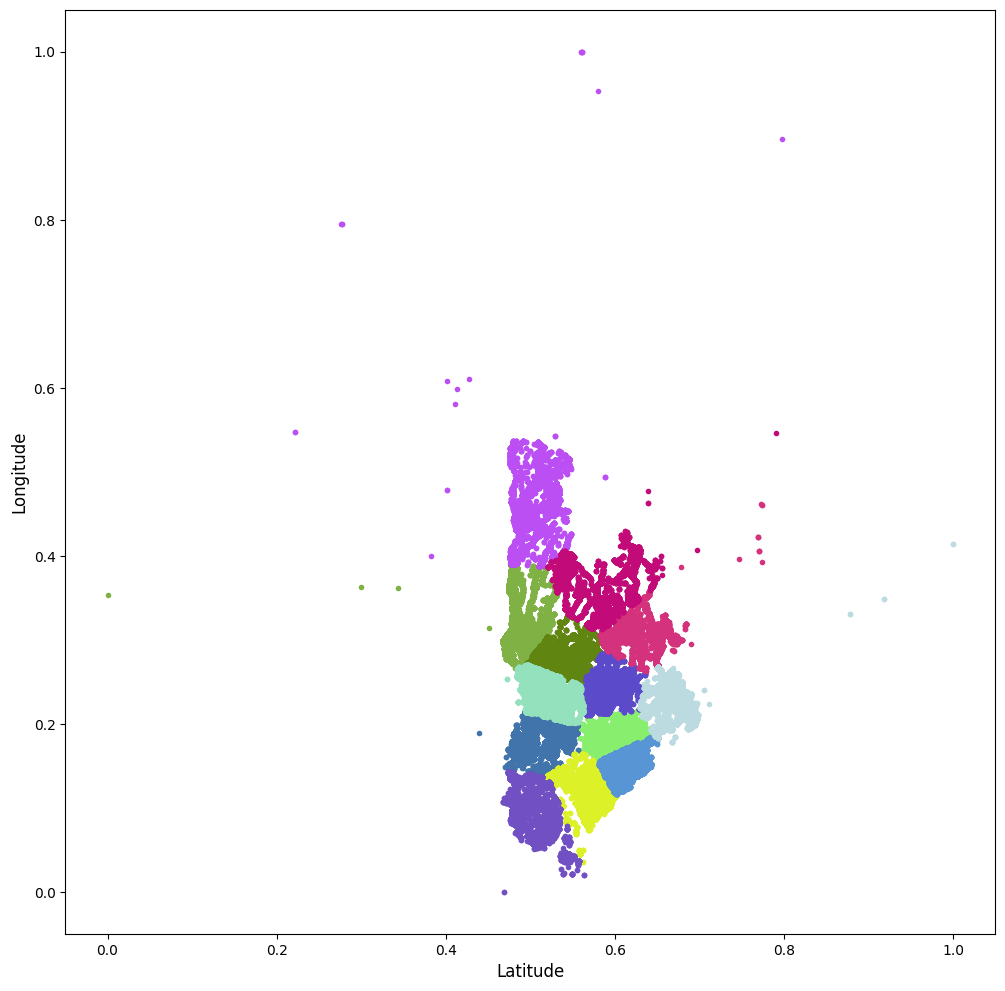

In [141]:
ptsymb = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(id_n)]

plt.figure(figsize=(12,12))
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
for i in range(id_n):
    cluster=np.where(id_label==i)[0]
    plt.scatter(X_full.latitude[cluster].values,
             X_full.longitude[cluster].values,
             c=ptsymb[i], marker='.')
plt.show()

#### Add clusters column

In [139]:
final_df['clusters'] = clusters

---

# Part 3:  exploratory analysis

### - Resulting table contains $764K$ points from $6.3K$ unique routes. Of all points $11$% were eventually removed.


In [41]:
print(final_df.shape[0], 
final_df[['folder_name', "code_digit"]].drop_duplicates().shape[0],
final_df.query("is_removed == 1").shape[0]/final_df.shape[0]*100)

764115 6302 10.864725859327457


In [6]:
final_df['from'] = pd.to_datetime(final_df['from'])
final_df['till'] = pd.to_datetime(final_df['till'])
final_df['time_period'] = final_df['till'] - final_df['from']
final_df['time_period'] = final_df['time_period'].apply(lambda x: x.total_seconds() / 60)

### - Of all points 85.6% have the same time window - ”07:30:00-23:59:00”

In [30]:
final_df['time_window_without_date'] = (
    final_df['from'].apply(lambda x: str(x).split(" ")[1]) 
    + "-" +
    final_df['till'].apply(lambda x: str(x).split(" ")[1])
)

final_df.groupby(['time_window_without_date']).size().sort_values(ascending=False)/final_df.shape[0]

time_window_without_date
07:30:00-23:59:00    0.855825
07:30:00-17:00:00    0.053987
08:00:00-17:00:00    0.011132
07:30:00-16:00:00    0.006775
09:00:00-17:00:00    0.006774
                       ...   
08:00:00-09:00:00    0.000001
07:30:00-20:59:00    0.000001
07:30:00-15:59:00    0.000001
07:30:00-13:35:00    0.000001
23:00:00-23:30:00    0.000001
Length: 325, dtype: float64

### - The percentage of points that are removed varies depending on the type of the trigger type

In [39]:
(final_df.groupby(["configurationName", "is_removed"]).size()/final_df.groupby(["configurationName"]).size())*100

configurationName  is_removed
AddToSequence      0             78.183362
                   1             21.816638
CreateSequence     0             91.910819
                   1              8.089181
EstimateTime       0             42.465184
                   1             57.534816
dtype: float64

---

### - Removed points are on average $1.22$ times further from the next stop than non-removed ones.

In [74]:
final_df.groupby("is_removed").agg({"distance": np.mean})

,distance
is_removed,
0,0.001301
1,0.001598


In [75]:
0.001598/0.001301

1.2282859338970022

---

### - Removed points on average have $1.13$ times more stops than non-removed ones.

In [76]:
final_df.groupby("is_removed").agg({"number_of_input_taks": np.mean})

,number_of_input_taks
is_removed,
0,147.458501
1,167.694877


In [77]:
167.694877/147.458501

1.1372343802681133

---

### - Cluster 3 has highest concentration of removed points ($16$%)
### - Cluster 12 has the least concentration of removed points ($3$%)

In [64]:
times_visited = (
final_df
.groupby(['clusters'])
.size()
.sort_values(ascending=False)
.reset_index(name='times_visited'))

times_removed = (
final_df
.query("is_removed ==1 ")
.groupby(['clusters'])
.size()
.sort_values(ascending=False)
.reset_index(name='times_removed'))


per_removed_from_neighb = pd.merge(times_visited, times_removed, on=['clusters'])
per_removed_from_neighb["%_removed"] = (per_removed_from_neighb["times_removed"]/
                                        per_removed_from_neighb["times_visited"]*100)

per_removed_from_neighb.sort_values("%_removed", ascending=False)


,clusters,times_visited,times_removed,%_removed
3,3,72323,11962,16.539690
7,5,54735,7933,14.493469
0,8,116130,15636,13.464221
1,10,100318,12676,12.635818
6,0,54862,6584,12.001021
5,4,60727,6841,11.265170
12,9,21936,2307,10.516958
4,11,63862,5283,8.272525
9,7,37489,2928,7.810291
2,1,74925,5616,7.495495


# Part 4: modelling

###  Fit two models and compare accuracies

In [137]:
sample_prop = 0.05
sample_size = int(final_df[['request_file_name']].drop_duplicates().shape[0]*sample_prop)
sample_files = (final_df[['request_file_name']].drop_duplicates()
                                               .sample(sample_size, random_state=1)['request_file_name'].values)

training = final_df.query("request_file_name in @sample_files")[['configurationName','distance', 
                                                                 'number_of_input_taks', 'clusters',
                                                                 'is_removed', 'time_period']]
training['distance'] = training['distance'].fillna(0)  

## Encode configurationName
le = LabelEncoder()
training['configurationName'] = le.fit_transform(training['configurationName'])


### Split test-train

In [139]:
X_train, X_test, y_train, y_test = train_test_split(training.drop('is_removed', axis=1), 
                                                    training['is_removed'], test_size=0.3, random_state=42)

### RandomForestClassifier has 92% accuracy

In [140]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9244240414860154


### LogisticRegression has 88% accuracy

In [144]:
lg = LogisticRegression(random_state=42)

lg.fit(X_train, y_train)

y_pred = lg.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.8795375329422767


---

### Summary of logistic regression results

In [154]:
X_train = sm.add_constant(X_train)

logit_model=sm.Logit(y_train, X_train).fit()
print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.309264
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             is_removed   No. Observations:                27445
Model:                          Logit   Df Residuals:                    27439
Method:                           MLE   Df Model:                            5
Date:                Sat, 22 Apr 2023   Pseudo R-squ.:                  0.1024
Time:                        19:03:52   Log-Likelihood:                -8487.7
converged:                       True   LL-Null:                       -9455.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -6.1382      0.144    -42.483      0.000      -6.421      -5.855